In [ ]:
import numpy as np
import torch
from einops import rearrange
from sklearn.decomposition import PCA
from tqdm.auto import tqdm

from diffusion_3d.chestct.autoencoder.vae.config import get_config
from diffusion_3d.chestct.autoencoder.vae.model import AdaptiveVAELightning
from diffusion_3d.datasets.ct_rate import CTRATEDataModule
from diffusion_3d.utils.visualize import plot_scans

[autoreload of diffusion_3d.datasets.ct_rate failed: Traceback (most recent call last):
  File "/home/ubuntu/miniconda3/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/ubuntu/miniconda3/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/home/ubuntu/miniconda3/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/home/ubuntu/miniconda3/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 365, in update_class
    update_instances(old, new)
  File "/home/ubuntu/miniconda3/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 323, in update_instances
    object.__setattr__(ref, "__class__", new)
TypeError: __class__ assignment: 'CTRATEDataset' object layout differs from 'CTRATEDataset'
]


In [ ]:
config = get_config()
config

Munch({'data': Munch({'csvpath': '/raid3/arjun/ct_pretraining/csvs/sources.csv', 'datapath': '/raid3/arjun/ct_pretraining/scans/', 'checkpointspath': '/raid3/arjun/checkpoints/adaptive_autoencoder/', 'limited_dataset_size': None, 'allowed_spacings': ((0.4, 7), (-1, -1), (-1, -1)), 'allowed_shapes': ((96, -1), (256, -1), (256, -1)), 'train_augmentations': Munch({'_target_': 'monai.transforms.Compose', 'transforms': [Munch({'_target_': 'monai.transforms.CropForegroundd', 'keys': ['image'], 'source_key': 'image'}), Munch({'_target_': 'monai.transforms.ScaleIntensityRanged', 'keys': ['image'], 'a_min': -1000, 'a_max': 2000, 'b_min': -1.0, 'b_max': 1.0, 'clip': True}), Munch({'_target_': 'monai.transforms.RandSpatialCropSamplesd', 'keys': ['image'], 'roi_size': (96, 96, 96), 'max_roi_size': (192, 192, 192), 'random_size': True, 'num_samples': 5}), Munch({'_target_': 'monai.transforms.Resized', 'keys': ['image'], 'spatial_size': (96, 96, 96), 'mode': 'trilinear', 'anti_aliasing': True}), Mun

In [ ]:
datamodule = CTRATEDataModule(config.data)
dataloader = datamodule.val_dataloader()
len(dataloader)

/home/ubuntu/miniconda3/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


valid:   0%|          | 0/2579 [00:00<?, ?it/s]

No. of valid datapoints: 2579


2579

In [ ]:
checkpoint_path = r"/raid3/arjun/checkpoints/adaptive_autoencoder/v25__2025_03_06/version_0/checkpoints/last.ckpt"

model = AdaptiveVAELightning.load_from_checkpoint(checkpoint_path, map_location="cpu", model_config=config.model)
model.eval()

/home/ubuntu/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/ubuntu/miniconda3/lib/python3.10/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.


AdaptiveVAELightning(
  (autoencoder): AdaptiveVAE(
    (encoder): SwinV23DModel(
      (patchify): PatchEmbeddings3D(
        (patch_embeddings): Conv3d(1, 24, kernel_size=(2, 2, 2), stride=(2, 2, 2))
        (normalization): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
      )
      (absolute_position_embeddings): AbsolutePositionEmbeddings3D()
      (encoder): SwinV23DEncoder(
        (stages): ModuleList(
          (0): SwinV23DStage(
            (blocks): ModuleList(
              (0-1): 2 x SwinV23DBlock(
                (w_layer): SwinV23DLayer(
                  (transformer): Attention3DWithMLP(
                    (attn): Attention3D(
                      (W_q): Linear(in_features=24, out_features=24, bias=True)
                      (W_k): Linear(in_features=24, out_features=24, bias=True)
                      (W_v): Linear(in_features=24, out_features=24, bias=True)
                      (proj): Linear(in_features=24, out_features=24, bias=True)
                 

In [11]:
with torch.no_grad():
    for i, batch in enumerate(dataloader):
        if i >= 1:
            break

        x = batch["image"][:2].to(model.device)

        reconstructed = model.process_step(x, "valid", 0)["reconstructed"].cpu()
        print(f"Batch idx: {i}")
        print(reconstructed.min(), reconstructed.max())
        print(x.shape, reconstructed.shape)
        print((x.min(), x.max()), (reconstructed.min(), reconstructed.max()))

        reconstructed[:, :, :, 0, 0] = -1.0
        reconstructed[:, :, :, -1, -1] = 1.0

        for i in range(x.shape[0]):
            plot_scans([x[i][0], reconstructed[i][0]], ["Original", "Reconstructed"])

torch.cuda.empty_cache()

/home/ubuntu/miniconda3/lib/python3.10/site-packages/lightning/pytorch/core/module.py:445: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


Batch idx: 0
metatensor(-0.7487) metatensor(0.2045)
torch.Size([2, 1, 96, 96, 96]) torch.Size([2, 1, 96, 96, 96])
(metatensor(-1.), metatensor(0.4347)) (metatensor(-0.7487), metatensor(0.2045))


interactive(children=(IntSlider(value=0, description='z', max=95), Output()), _dom_classes=('widget-interact',…

interactive(children=(IntSlider(value=0, description='z', max=95), Output()), _dom_classes=('widget-interact',…

# PCA

In [ ]:
raise Exception("Don't want to automatically run beyond this point")

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 raise Exception("Don't want to automatically run beyond this point")                         │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
Exception: Don't want to automatically run beyond this point

In [ ]:
import gc
from collections import defaultdict

device = torch.device('cuda:0')

latent_vectors = []
stage_output_vectors = defaultdict(list)

model_device = model.device
model.to(device)

with torch.no_grad():
    for batch in tqdm(dataloader):
        x = batch["scan"].to(device)
        mu, _, stage_outputs = model.encode(x, return_stage_outputs=True)
        x.cpu()
        del x
        latent_vectors.append(mu.cpu().numpy())
        for i in range(len(stage_outputs)):
            stage_output_vectors[i].append(stage_outputs[i].cpu().numpy())

model.to(model_device)
gc.collect()
torch.cuda.empty_cache()

latent_vectors = np.concatenate(latent_vectors, axis=0)

  0%|          | 0/129 [00:00<?, ?it/s]

In [ ]:
pattern = "b c z y x -> (b z y x) c"
# pattern = "b c z y x -> b (c z y x)"

latent_vectors_rearranged = rearrange(latent_vectors, pattern)
for i in range(len(stage_output_vectors)):
    stage_output_vectors[i] = np.concatenate(stage_output_vectors[i], axis=0)
    stage_output_vectors[i] = rearrange(stage_output_vectors[i], pattern)

for name, fit_vectors in [(f"Stage {i+1}", stage_output_vectors[i]) for i in range(len(stage_output_vectors))] + [
    ("Sampled", latent_vectors_rearranged)
]:
    try:
        # Compute PCA
        pca = PCA()
        pca.fit(fit_vectors)

        # Calculate effective dimensionality
        explained_variance_ratio = pca.explained_variance_ratio_
        cumulative_variance = np.cumsum(explained_variance_ratio)
        effective_dim = np.argmax(cumulative_variance > 0.95) + 1

        print(
            f"Effective dim {name}: {effective_dim} / {fit_vectors.shape[1]}\t({int(effective_dim * 100 / fit_vectors.shape[1])}%)"
        )
    except Exception as e:
        print(f"Failed to compute PCA for {name}: {e}")

Effective dim Stage 1: 15 / 36	(41%)
Effective dim Stage 2: 9 / 72	(12%)
Effective dim Stage 3: 11 / 144	(7%)
Effective dim Sampled: 9 / 144	(6%)


# Visualize patches

In [ ]:
from matplotlib import pyplot as plt

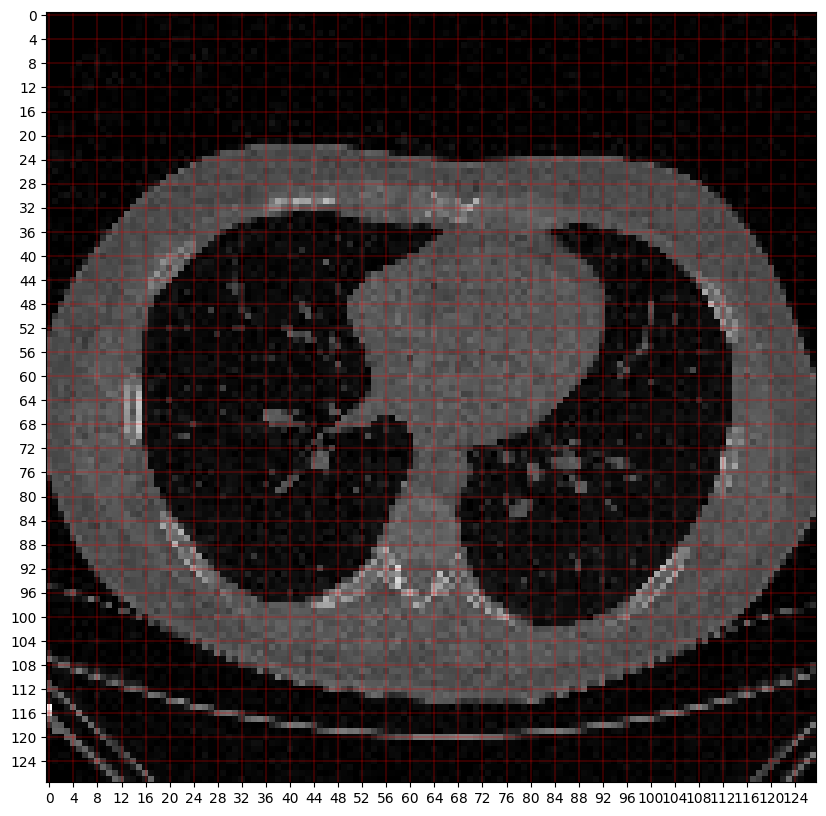

In [ ]:
patch_size = 4

x = batch['scan']

plt.figure(figsize=(10, 10))
plt.imshow(x[0][0][128], cmap="gray")
plt.grid(color="r", linestyle="-", linewidth=0.3)
plt.gca().set_xticks(np.arange(0, x.shape[-1], patch_size))
plt.gca().set_yticks(np.arange(0, x.shape[-1], patch_size))
plt.show()

# Check latent space

In [ ]:
raise Exception("Don't want to automatically run beyond this point")

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 raise Exception("Don't want to automatically run beyond this point")                         │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
Exception: Don't want to automatically run beyond this point

In [ ]:
dataloader_iter = iter(dataloader)
batch1 = next(dataloader_iter)
batch2 = next(dataloader_iter)
x1, x2 = batch1["scan"], batch2["scan"]
(batch1["uid"], batch2["uid"]), (x1.shape, x2.shape)


(
    (
        ['train_17513_a_1', 'train_3173_a_1', 'train_19337_d_1'],
        ['train_19337_a_1', 'train_14119_a_1', 'train_18480_a_1']
    ),
    (torch.Size([3, 1, 256, 256, 256]), torch.Size([3, 1, 256, 256, 256]))
)

In [ ]:
with torch.no_grad():
    output1 = model.process_step(x1, [], "valid", 0)
    output2 = model.process_step(x2, [], "valid", 0)

reconstructed1 = output1["reconstructed"]
reconstructed2 = output2["reconstructed"]

adapted_encoded1 = output1["adapted_encoded"]
adapted_encoded2 = output2["adapted_encoded"]

(reconstructed1.shape, reconstructed2.shape), (adapted_encoded1.shape, adapted_encoded2.shape)

/home/ubuntu/miniconda3/lib/python3.10/site-packages/lightning/pytorch/core/module.py:445: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`



(
    (torch.Size([3, 1, 256, 256, 256]), torch.Size([3, 1, 256, 256, 256])),
    (torch.Size([3, 768, 24, 8, 8]), torch.Size([3, 768, 24, 8, 8]))
)

In [ ]:
adapted_encoded_inter = (adapted_encoded1 + adapted_encoded2) / 2
adapted_encoded_inter.shape

torch.Size([3, 768, 24, 8, 8])

In [ ]:
from torch.nn import functional as F

with torch.no_grad():
    decoded_inter = model.decode(adapted_encoded_inter)
    reconstructed_inter = F.interpolate(decoded_inter, x1.shape[2:], mode="trilinear")
reconstructed_inter.shape

torch.Size([3, 1, 256, 256, 256])

In [ ]:
plot_scans(
    [x1[0][0], x2[0][0], reconstructed1[0][0], reconstructed2[0][0], reconstructed_inter[0][0]],
    ["Scan1", "Scan2", "Reconstructed1", "Reconstructed2", "Reconstructed interpolated latent"],
    cols=2,
)

interactive(children=(IntSlider(value=0, description='z', max=255), Output()), _dom_classes=('widget-interact'…

In [ ]:
plot_scans((reconstructed1 - reconstructed2).abs()[0][0])

interactive(children=(IntSlider(value=0, description='z', max=255), Output()), _dom_classes=('widget-interact'…